# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [2]:
from platform import python_version
print(python_version())

3.6.3


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Show the shape of the dataframes
portfolio.shape, profile.shape, transcript.shape



((10, 6), (17000, 5), (306534, 4))

# 1. Exploring the data

First of all, let's take a look at how the data is organized. The objective is to verify which type of data is present in each of the three Json file. 

## 1.1. Taking a look at the starbucks portifolio

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


Text(0,0.5,'Frequency')

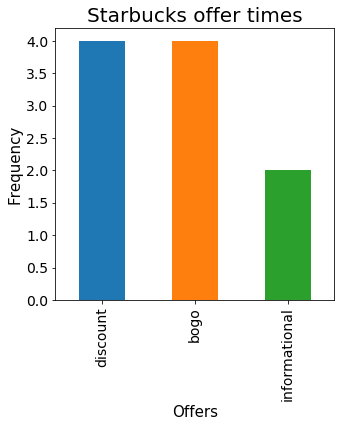

In [6]:
# Count the number of offer types
ax = portfolio["offer_type"].value_counts().plot.bar(figsize=(5,5),fontsize=14)

ax.set_title("Starbucks offer times", fontsize=20)
ax.set_xlabel("Offers", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)


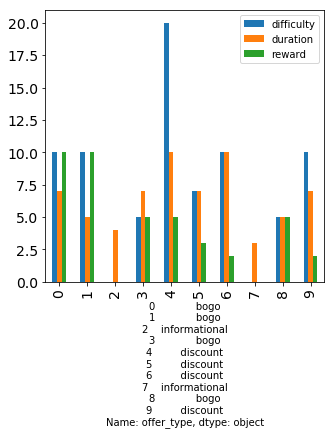

In [7]:
# Visualise the portifolio dataset
portfolio.plot.bar(figsize=(5,5),fontsize=14)
plt.xlabel(portfolio['offer_type'])
plt.show()

In [8]:
def clean_portfolio(portfolio):
    '''
        INPUT:
        portfolio : dataframe containing the Starbucks offer portfolio
        
        OUTPUT:
        portfolio_clean: cleaned dataframe with dummy variables for each channel communication
    '''
    # Create dummy variables for each communication channel
    dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
    portfolio_clean = pd.concat([portfolio, dummy], axis=1)
    portfolio_clean = portfolio_clean.drop(columns='channels')
    
    return portfolio_clean

portfolio_clean = clean_portfolio(portfolio)
portfolio_clean


,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [9]:
offer_type = list(set(portfolio['offer_type']))
print('** Portfolio data analysis **')
print('Number of offer type:', len(offer_type))
print('Number of unique ids:', len(set(portfolio['id'])))

** Portfolio data analysis **
Number of offer type: 3
Number of unique ids: 10


From the above analysis, it is possible to observe that the Portifolio Dataframe contains the information about the type of offers that Starbucks can offer to its clients. There are 10 different offers IDs that distinguish each other depending of the duration, difficulty, type of promotion, and channels of diffusions (email, web, social media, etc). There are in total 3 type of offers: discount, bogo and informational. Remarkably, this dataset there is no missing values.  

## 1.2. Taking a look at the client profiles

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [163]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [164]:
print('** Profile data analysis **')
print('Dataframe size:',profile.shape)
print('Number of unique users:', len(set(profile['id'])))
print('Number of ages equal to 118:',np.sum(profile['age'] == 118))
print('Number of null values in gender column:',np.sum(profile['gender'].isnull()))
print('Number of null values in income column:',np.sum(profile['income'].isnull()))
print('Number of null values in became_member_on column:',np.sum(profile['became_member_on'].isnull()))


** Profile data analysis **
Dataframe size: (17000, 5)
Number of unique users: 17000
Number of ages equal to 118: 2175
Number of null values in gender column: 2175
Number of null values in income column: 2175
Number of null values in became_member_on column: 0


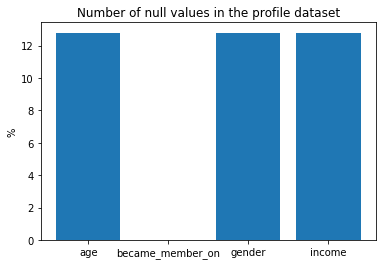

In [11]:
# Calculate the percentage of NaN values and age equals to 118 years old
age_118_per = 100*(np.sum(profile['age'] == 118)/ len(profile['age']))

gender_null_per  = 100*(1 - len(profile['gender'].dropna())/len(profile['gender']))
income_null_per  = 100*(1 - len(profile['income'].dropna())/len(profile['gender']))
became_member_on  = 100*(1 - len(profile['became_member_on'].dropna())/len(profile['became_member_on']))

# Create bar graphs showing the percentage of NaN values and age equal to 118
x = ['age','gender','income','became_member_on']
y = [age_118_per,gender_null_per,income_null_per,became_member_on]
plt.bar(x,y)
plt.ylabel('%')
plt.title('Number of null values in the profile dataset')
plt.show()


From the above table, it is notable that there are some ages that is worth 118, which is unreal. In additional, there are some missing values in the income and gender columns. Therefore, firstly, it is necessary to clean this data.

## 1.3. Taking a look at transaction dataframe

In [166]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [167]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [168]:
print('Number of unique users in the transcript: ', len(transcript.groupby('person')))

Number of unique users in the transcript:  17000


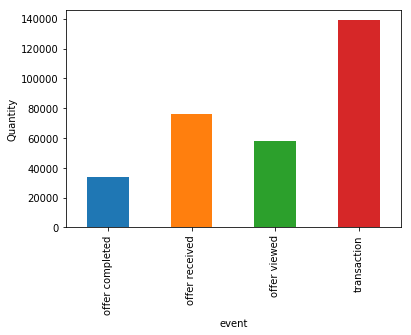

In [12]:
transcript.groupby('event').count().iloc[:,0].plot.bar()

plt.ylabel('Quantity')
plt.show()


In [13]:
transcript.groupby('person').count().head()

,event,time,value
person,,,
0009655768c64bdeb2e877511632db8f,20,20,20
00116118485d4dfda04fdbaba9a87b5c,7,7,7
0011e0d4e6b944f998e987f904e8c1e5,18,18,18
0020c2b971eb4e9188eac86d93036a77,19,19,19
0020ccbbb6d84e358d3414a3ff76cffd,23,23,23


In [171]:
print('Average number of historic in the transcrip per client:', transcript.groupby('person').count().mean()[0])

Average number of historic in the transcrip per client: 18.0314117647


In [14]:
# Example of historic transcript for a specific client
client_id = "0009655768c64bdeb2e877511632db8f"
transcript[transcript['person'] == client_id]

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


The dataframe 'Transcript' contains 306534 rows with no null values. It is possible to note that for a unique client ID (person), there are more than one trasaction. By selecting a client ID (e.g. "0009655768c64bdeb2e877511632db8f") in the 'Transcript' dataframe, it is possible to obtain the historic data of the iteraction between the client and the offer. Nonetheless, this data need to be cleaned to access the information easialy.

# 2. Cleaning data

Based on the briefly analysis above, it was constated that the data in the 'profile' and 'trasaction' need to be cleaned and restructure to access the information easialy.

## 2.1. Cleaning User Profile Dataframe

The cleaning process of the user profile dataframe consist of erasing the user who has age equal to 118 and that did not informed their income. Furthermore, the column **became_member_on** will be replaced by the number of days the user is Starbucks client member. To implement this cleaning process, the function **clean_user_profile_dataframe** was created.

In [15]:
def clean_user_profile_dataframe(profile):
    '''
        INPUT:
        profile : original dataframe containing client profiles
        
        OUTPUT:
        profile_clean: cleaned dataframe with dummy variables for each gender and without age 118
    '''
    #-----------------------------------
    # Remove users who age equals to 118
    #-----------------------------------
    profile_clean = profile.drop(profile[profile['age'] == 118].index)
    
    #-----------------------------------
    # Remove users who the income is NaN
    #-----------------------------------
    profile_clean = profile_clean.drop(profile_clean[profile_clean['income'] == np.nan].index)
    
    #--------------------------------------------
    # Replace 'became_member_on' by 'client_time'
    #--------------------------------------------
    # Calculate the number of days the user is client member of Starbucks
    duration_client = lambda x: (datetime.now() - datetime(int(str(x)[0:4]), int(str(x)[4:6]),
                                                           int(str(x)[6:8]), 0, 0, 0) ).days
    # Create a new column called 'client_duration_days'
    profile_clean['client_duration_days'] = profile_clean['became_member_on'].apply(duration_client)
    
    # Delete the column 'became_member_on'
    profile_clean = profile_clean.drop(['became_member_on'], axis=1)
    
    # Create dummy categories of genders
    dummy_gender = pd.get_dummies(profile_clean['gender']);
    
    # Merge the profile_clean Dataframe with the categorical datagrame with client gender
    profile_clean = profile_clean.reset_index(drop=True).merge(dummy_gender.reset_index(drop=True), left_index=True, right_index=True)
    
    # Delete the original 'gender' columns
    profile_clean = profile_clean.drop(['gender'],axis = 1)
    
    # Put the client ids in the index of the dataframe
    profile_clean.index = profile_clean['id']
    profile_clean = profile_clean.drop(['id'],axis = 1)
    
    return profile_clean

# Clean the profile dataframe
profile_clean = clean_user_profile_dataframe(profile)
profile_clean.head()

,age,income,client_duration_days,F,M,O
id,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1390,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1457,1,0,0
e2127556f4f64592b11af22de27a7932,68,70000.0,1105,0,1,0
389bc3fa690240e798340f5a15918d5c,65,53000.0,1181,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,1271,0,1,0


Number of woman:  6129
Number of man: 8484
Number of O: 212


Text(0.5,1,'Client profile by gender')

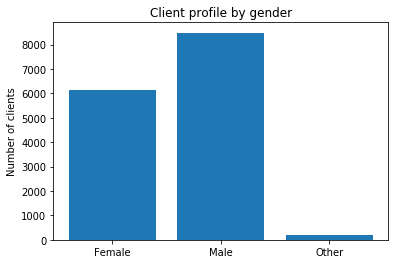

In [16]:
# Show some statistics about the profile_clean dataframe
print('Number of woman: ',len(profile_clean[profile_clean['F'] == 1]))
print('Number of man:',len(profile_clean[profile_clean['M'] == 1]))
print('Number of O:',len(profile_clean[profile_clean['O'] == 1]))

x = ['Female','Male','Other']
y = [len(profile_clean[profile_clean['F'] == 1]),
     len(profile_clean[profile_clean['M'] == 1]),
     len(profile_clean[profile_clean['O'] == 1])]
plt.bar(x,y)
plt.ylabel('Number of clients')
plt.title('Client profile by gender')

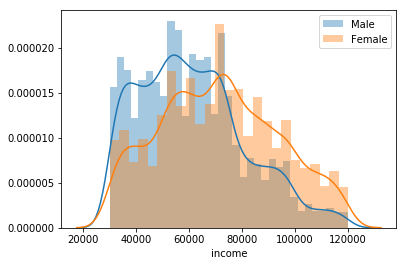

Average income of man: 61194.601603
Average income of woman: 71306.412139


1.1652402380456908

In [175]:
## Gender-wise Income Distribution
sns.distplot(profile_clean[profile_clean.M == 1].income,label='Male')
sns.distplot(profile_clean[profile_clean.F == 1].income,label='Female')
plt.legend()
plt.show()

print('Average income of man:' , profile_clean[profile_clean.M == 1]['income'].mean())
print('Average income of woman:' ,profile_clean[profile_clean.F == 1]['income'].mean())

profile_clean[profile_clean.F == 1]['income'].mean()/profile_clean[profile_clean.M == 1]['income'].mean()

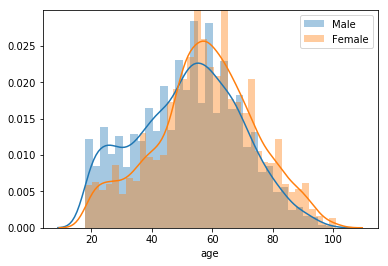

Average age of man: 52.1166902405
Average age of woman: 57.5449502366


1.1652402380456908

In [176]:
## Gender-wise Income Distribution
sns.distplot(profile_clean[profile_clean.M == 1].age,label='Male')
sns.distplot(profile_clean[profile_clean.F == 1].age,label='Female')
plt.legend()
plt.show()

print('Average age of man:' , profile_clean[profile_clean.M == 1]['age'].mean())
print('Average age of woman:' ,profile_clean[profile_clean.F == 1]['age'].mean())

profile_clean[profile_clean.F == 1]['income'].mean()/profile_clean[profile_clean.M == 1]['income'].mean()

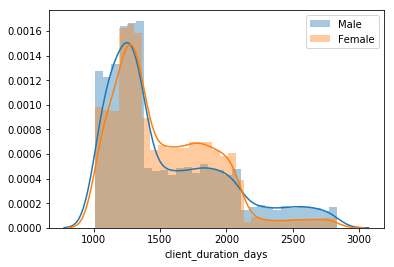

Average client time of man (days): 1543.09653465
Average client time of woman (days): 1526.15532713


0.98902129118968618

In [177]:
## Gender-wise Income Distribution
sns.distplot(profile_clean[profile_clean.M == 1].client_duration_days,label='Male')
sns.distplot(profile_clean[profile_clean.F == 1].client_duration_days,label='Female')
plt.legend()
plt.show()

print('Average client time of man (days):' , profile_clean[profile_clean.M == 1]['client_duration_days'].mean())
print('Average client time of woman (days):' ,profile_clean[profile_clean.F == 1]['client_duration_days'].mean())

profile_clean[profile_clean.F == 1]['client_duration_days'].mean()/profile_clean[profile_clean.M == 1]['client_duration_days'].mean()

From the two graphs above, it is possible to note that there are about 38% more man than woman among the Starbucks clients. This demonstrates that the data is a bit unbalanced. Additionally, the average age of man and woman are 52 and 57 years old, respectively. 

## 2.2 Cleaning of Transactions Dataframe


To clean the _Trasaction_ Dataframe, it will be identified all the offers received, viewed and completed per user present into the dataframe **profile_clean**. These data will be reorganised into a new dataframe called **transaction_cleaned** through the functions **calculate_net_revenue_per_client**.

In [178]:
# Example of a transcript for a specific client
transcript_client = transcript[transcript['person'] == profile_clean.index[1]]
transcript_client

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [179]:
def calculate_net_revenue_per_client(transcript,portfolio,profile_clean,cost_advertisement = 0.1, show_debug = False):
    '''
        INPUT:
        transcript : original dataframe containing client transcript
        portfolio:  original dataframe containing offer portfolio
        profile_clean: cleaned dataframe containing the client profile
        cost_advertisement: the cost of advertisement
        show_debug: Bool variable indicating whether the results will be printed or not
        
        OUTPUT:
        df_client_offer: a dataframe linking the offer and client IDs with the expected net revenur
    '''
    # Create empty lists to store the variables
    is_offer_viewed_list = [];
    is_offer_completed_list = [];
    net_revenue_list = [];
    client_id_list = []
    offer_id_list = []
    
    count = 0
    for client_id in profile_clean.index:
        count += 1
        print(count, '/',len(profile_clean.index))
        
        if show_debug:
            print('Client ID:',client_id)
        # Select the client_id in the transcript dataframe
        transcript_client = transcript[transcript['person'] == client_id]

        # Get the id of the offers received
        all_offer_received = transcript_client[transcript_client['event'] == 'offer received']['value']
        all_offer_received_time = transcript_client[transcript_client['event'] == 'offer received']['time']
        all_offer_received_id = list(all_offer_received.apply(lambda x : x['offer id']))
        try:
            all_offer_received_time_next = list(all_offer_received_time).pop()
        except:
            all_offer_received_time_next = []
        
        
        # Get the id of the offers viewed
        all_offer_viewed = transcript_client[transcript_client['event'] == 'offer viewed']['value']
        all_offer_viewed_time = transcript_client[transcript_client['event'] == 'offer viewed']['time']
        all_offer_viewed_id = list(all_offer_viewed.apply(lambda x : x['offer id']))
        

        # Get the id of the offers completed
        all_offer_completed = transcript_client[transcript_client['event'] == 'offer completed']['value']
        all_offer_completed_time = transcript_client[transcript_client['event'] == 'offer completed']['time']
        all_offer_completed_id = list(all_offer_completed.apply(lambda x : x['offer_id']))
    
        time_offer_completed = transcript_client[transcript_client['event'] == 'offer completed']['time']

        # Get all the transactions
        transaction_time = transcript_client[transcript_client['event'] == 'transaction']['time']
        transaction_amount = transcript_client[transcript_client['event'] == 'transaction']['value'].apply(lambda x : x['amount'])
        transaction_amount = np.array(transaction_amount)

        # Calculte the net revenue for each offer received
        index = 0
        for offer_received_id, offer_received_time in zip(all_offer_received_id,
                                                          all_offer_received_time,
                                                          ):
            # Store the client and offer IDs in a list
            client_id_list.append(client_id)
            offer_id_list.append(offer_received_id)
            
            if show_debug:
                print(' ')
                print('Offer received:', offer_received_id, 'at ', offer_received_time)
            

            # Verify whether the offer was completed
            if offer_received_id in all_offer_completed_id:
                is_offer_completed = True
            else:
                is_offer_completed = False               
            is_offer_completed_list.append(is_offer_completed)
            
            # For each offer received and viewed, calculte the net revenue
            if offer_received_id in all_offer_viewed_id:
                is_offer_viewed = True

                # Get all transactions after the user has viewed the offer and before the offer time expiration
                if index < len(np.array(all_offer_received_time)) - 1:
                    next_offer_time = np.array(all_offer_received_time)[index +1]
                else:
                    next_offer_time = 10000000000000    
                
                offer_time_duration = np.array(portfolio[portfolio['id'] == offer_received_id]['duration'])[0]*24 # Duration time of the offer in hours
                reward = np.array(portfolio[portfolio['id'] == offer_received_id]['reward'])[0]
                total_revenue = np.sum(transaction_amount[(list(np.where(np.array(transaction_time < (next_offer_time)) & 
                                          (transaction_time > offer_received_time))[0]))])

                net_revenue = total_revenue - reward*is_offer_completed - cost_advertisement;
                net_revenue_list.append(net_revenue)

                if show_debug:
                    print('Offer received time', offer_received_time)
                    print('Offer received time next',next_offer_time)
                    print('Offer duration: ',offer_time_duration )
                    print('Offer total transaction : ', total_revenue)
                    print('Offer reward : ',reward  )
                    print('Net revenue: ', net_revenue)

            else:
                is_offer_viewed = False
                net_revenue_list.append(-cost_advertisement)
                
            is_offer_viewed_list.append(is_offer_viewed) 

            index += 1
            
            if show_debug:
                print('Is offer viewed:', is_offer_viewed)
                print('Is offer completed:', is_offer_completed)

    # Create dataframe with the key results
    data_dict = {'client_id': client_id_list,
                 'offer_id': offer_id_list,
                 'is_offer_viewed': is_offer_viewed_list,
                 'is_offer_completed': is_offer_completed_list,
                 'net_revenue': net_revenue_list
                }
    df_client_offer = pd.DataFrame(data = data_dict)
    return df_client_offer

df_client_offer = calculate_net_revenue_per_client(transcript,portfolio,profile_clean,cost_advertisement = 0.1,show_debug = False)

1 / 14825
2 / 14825
3 / 14825
4 / 14825
5 / 14825
6 / 14825
7 / 14825
8 / 14825
9 / 14825
10 / 14825
11 / 14825
12 / 14825
13 / 14825
14 / 14825
15 / 14825
16 / 14825
17 / 14825
18 / 14825
19 / 14825
20 / 14825
21 / 14825
22 / 14825
23 / 14825
24 / 14825
25 / 14825
26 / 14825
27 / 14825
28 / 14825
29 / 14825
30 / 14825
31 / 14825
32 / 14825
33 / 14825
34 / 14825
35 / 14825
36 / 14825
37 / 14825
38 / 14825
39 / 14825
40 / 14825
41 / 14825
42 / 14825
43 / 14825
44 / 14825
45 / 14825
46 / 14825
47 / 14825
48 / 14825
49 / 14825
50 / 14825
51 / 14825
52 / 14825
53 / 14825
54 / 14825
55 / 14825
56 / 14825
57 / 14825
58 / 14825
59 / 14825
60 / 14825
61 / 14825
62 / 14825
63 / 14825
64 / 14825
65 / 14825
66 / 14825
67 / 14825
68 / 14825
69 / 14825
70 / 14825
71 / 14825
72 / 14825
73 / 14825
74 / 14825
75 / 14825
76 / 14825
77 / 14825
78 / 14825
79 / 14825
80 / 14825
81 / 14825
82 / 14825
83 / 14825
84 / 14825
85 / 14825
86 / 14825
87 / 14825
88 / 14825
89 / 14825
90 / 14825
91 / 14825
92 / 148

In [56]:
# Save cleaned client transcript to csv file
df_client_offer.to_csv('df_client_offer.csv',index = False)

In [17]:
# Read cleaned client transcript to csv file
df_client_offer = pd.read_csv('df_client_offer.csv')
df_client_offer.head(10)

,client_id,offer_id,is_offer_viewed,is_offer_completed,net_revenue
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,True,-0.10
1,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,False,False,-0.10
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,32.57
3,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,True,False,73.22
4,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,True,True,-10.10
5,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,True,True,43.18
6,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,True,False,39.21
7,e2127556f4f64592b11af22de27a7932,3f207df678b143eea3cee63160fa8bed,False,False,-0.10
8,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,-5.10
9,e2127556f4f64592b11af22de27a7932,fafdcd668e3743c1bb461111dcafc2a4,True,True,16.32


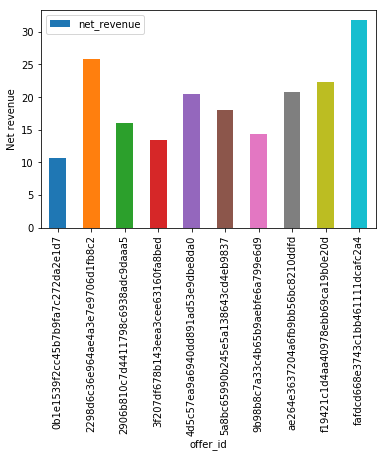

In [18]:
# Visualise in bar graphs the average revenue per offer
df_client_offer.groupby(['offer_id']).mean().reset_index().plot.bar(x='offer_id', y='net_revenue')
plt.ylabel('Net revenue')
plt.show()

In [19]:
# Show the average performance for each offer
df_client_offer.groupby(['offer_id']).mean()

,is_offer_viewed,is_offer_completed,net_revenue
offer_id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,0.376450,0.542670,10.617768
2298d6c36e964ae4a3e7e9706d1fb8c2,0.972201,0.771450,25.800780
2906b810c7d4411798c6938adc9daaa5,0.582265,0.637310,16.036506
3f207df678b143eea3cee63160fa8bed,0.578489,0.000000,13.429740
4d5c57ea9a6940dd891ad53e9dbe8da0,0.972850,0.540422,20.438412
5a8bc65990b245e5a138643cd4eb9837,0.916754,0.000000,17.954257
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.583994,0.676739,14.368539
ae264e3637204a6fb9bb56bc8210ddfd,0.911267,0.582672,20.750335
f19421c1d4aa40978ebb69ca19b0e20d,0.973540,0.675182,22.304208


In [20]:
# Join the client profile data with offer net revenue in a unique dataframe and portfolio channels
portfolio_clean.index = portfolio_clean['id']
channel_portifolio = portfolio_clean.iloc[:,-4:]

df_client_profile_offer = df_client_offer.set_index('offer_id').join(channel_portifolio)
df_client_profile_offer = df_client_profile_offer.rename_axis('offer_id').reset_index()
df_client_profile_offer = df_client_profile_offer.set_index('client_id').join(profile_clean)
df_client_profile_offer = df_client_profile_offer.rename_axis('client_id').reset_index()


In [21]:
# Show the joined dataframe
df_client_profile_offer.head()

,client_id,offer_id,is_offer_viewed,is_offer_completed,net_revenue,email,mobile,social,web,age,income,client_duration_days,F,M,O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,False,True,-0.10,1,1,0,1,33,72000.0,1475,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,True,False,-0.10,1,1,0,1,33,72000.0,1475,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,True,False,22.06,1,1,1,0,33,72000.0,1475,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,True,True,3.47,1,1,1,1,33,72000.0,1475,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,True,True,25.57,1,1,1,1,33,72000.0,1475,0,1,0


In [22]:
df_client_profile_offer_mean = df_client_profile_offer.iloc[:,2:].mean().reset_index()
df_client_profile_offer_mean.columns= ['Information','Average']
df_client_profile_offer_mean

,Information,Average
0,is_offer_viewed,0.783417
1,is_offer_completed,0.520549
2,net_revenue,19.326733
3,email,1.000000
4,mobile,0.898859
5,social,0.598517
6,web,0.799612
7,age,54.369258
8,income,65371.618472
9,client_duration_days,1535.901174


# 3. Create a machine learning model to build a recommendation engine

The idea of the recommendation engine is to create a linear regression model to estimate the net revenue of each offer based on the client profile. For this, it will be created a linear regression model for each offer ID to determine a model that links the client profile to the expected net offer revenue.

Thereafter, for each new client, the ten predicted model (for each offer) will be run to predict the expected net revenue that the client will give to Startbucks after receiving the offer. Based on these results, the offer with the highest net revenue will be sent to the client.

As first step, it will be analysed how the linear model will be built. It will be investigated which features are the best to be used to predict the revenue. Therefore, three different models will be compared, namely:

- A baseline model that uses only the client gender. It is a very simple model that enables us to verify whether the model is predicting well because it can be compared with the average value of the whole dataset.
- A model based on the whole client profile.
- A model based on the whole client profile and the offer channel (email, web, sms, etc)

First, we are going to import all  necessary  machine learning libraries.


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.metrics import accuracy_score

In [90]:
def train_RandomForestModel( num_features,model_name,k_fold = 2, show_results = True):

    # Get all offers ids
    offer_ids = portfolio['id']

    # Create a linear regression model for each offer_id
    net_revenue_list = []
    all_mse = []

    for offer_id in offer_ids:

        # Select the data by offer id
        df_offer_id = df_client_profile_offer[df_client_profile_offer['offer_id'] == offer_id]

        Xt = df_offer_id.iloc[:,-num_features:].values # Get the data referring to client profile
        yt = df_offer_id['net_revenue'].values # Get the net revenue

        net_revenue_list.append(np.mean(yt))

        # Create the Random Forest model
        estimator = RandomForestRegressor()
        param_grid = {
            "n_estimators" : [10,30],
            "min_samples_split": [2,4],
            "bootstrap": [True,False]
        }
        model = GridSearchCV(estimator, param_grid, n_jobs = -1, cv = 5)

        #Implementing cross validation
        k = k_fold
        kf = KFold(n_splits=k, random_state=1)

        mse_score = []    
        for train_index , test_index in kf.split(Xt):
            X_train , X_test = Xt[train_index,:],Xt[test_index,:]
            y_train , y_test = yt[train_index] , yt[test_index]

            model.fit(X_train,y_train)
            yt_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, yt_pred)
            mse_score.append(mse)

        avg_mse_score = sum(mse_score)/k

        # Save model in a pickle file
        pkl_filename = "pickle_" + model_name + "_model_revenue_" + offer_id + ".pkl"
        with open(pkl_filename, 'wb') as file:
            pickle.dump(model, file)

        if show_results:
            print('--------------------------------------------------------------------- ')
            print('Offer:',offer_id)
            print('Pickle file:',pkl_filename)
            print('MSE: ', mse_score)
            print('Average mse (net revenue):', avg_mse_score)
            print('Best param:', model.best_params_)



        all_mse.append(avg_mse_score)


    return all_mse

In [147]:
def train_LinearRegressionModel( num_features,model_name,k_fold = 2, show_results = True):

    # Get all offers ids
    offer_ids = portfolio['id']

    # Create a linear regression model for each offer_id
    net_revenue_list = []
    all_mse = []

    for offer_id in offer_ids:

        # Select the data by offer id
        df_offer_id = df_client_profile_offer[df_client_profile_offer['offer_id'] == offer_id]

        Xt = df_offer_id.iloc[:,-num_features:].values # Get the data referring to client profile
        yt = df_offer_id['net_revenue'].values # Get the net revenue

        net_revenue_list.append(np.mean(yt))

        # Create the Linear Regression model
        model = LinearRegression(normalize=True)

        #Implementing cross validation
        k = k_fold
        kf = KFold(n_splits=k, random_state=1)

        mse_score = []    
        for train_index , test_index in kf.split(Xt):
            X_train , X_test = Xt[train_index,:],Xt[test_index,:]
            y_train , y_test = yt[train_index] , yt[test_index]

            model.fit(X_train,y_train)
            yt_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, yt_pred)
            mse_score.append(mse)

        avg_mse_score = sum(mse_score)/k

        # Save model in a pickle file
        pkl_filename = "pickle_" + model_name + "_model_revenue_" + offer_id + ".pkl"
        with open(pkl_filename, 'wb') as file:
            pickle.dump(model, file)

        if show_results:
            print('--------------------------------------------------------------------- ')
            print('Offer:',offer_id)
            print('Pickle file:',pkl_filename)
            print('MSE: ', mse_score)
            print('Average mse (net revenue):', avg_mse_score)
            

        all_mse.append(avg_mse_score)


    return all_mse

## 3.1 The baseline model:

To verify whether the predicted model works correctly, a simple model which uses only the client gender (i.e. F, M and O) as feature will be evaluated. The evaluation consist of comparing the predicted value for the three possible input values (i.e. [1 0 0], [0 1 0], and [0 0 1]) with the classified average of net revenue of the whole dataset.

In [74]:
all_mse_baseline_lr = train_LinearRegressionModel(3,"baselineLR",k_fold = 5)

--------------------------------------------------------------------- 
Offer: ae264e3637204a6fb9bb56bc8210ddfd
Pickle file: pickle_baselineLR_model_revenue_ae264e3637204a6fb9bb56bc8210ddfd.pkl
MSE:  [2678.3895296663186, 1332.9922977478896, 2166.8475195743713, 3625.5266525865509, 2911.7594040348799]
Average mse (net revenue): 2543.10308072
--------------------------------------------------------------------- 
Offer: 4d5c57ea9a6940dd891ad53e9dbe8da0
Pickle file: pickle_baselineLR_model_revenue_4d5c57ea9a6940dd891ad53e9dbe8da0.pkl
MSE:  [1566.8652535796016, 3247.5127416520199, 2612.9961856590194, 1943.5730540659229, 4261.5605458969003]
Average mse (net revenue): 2726.50155617
--------------------------------------------------------------------- 
Offer: 3f207df678b143eea3cee63160fa8bed
Pickle file: pickle_baselineLR_model_revenue_3f207df678b143eea3cee63160fa8bed.pkl
MSE:  [1259.5589757260525, 894.53993005633743, 700.44293585781043, 1454.1975244836935, 2243.8825917469685]
Average mse (net r

In [91]:
all_mse_baseline = train_RandomForestModel(3,"baselineRF",k_fold = 5)

--------------------------------------------------------------------- 
Offer: ae264e3637204a6fb9bb56bc8210ddfd
Pickle file: pickle_baselineRF_model_revenue_ae264e3637204a6fb9bb56bc8210ddfd.pkl
MSE:  [2677.8695039429258, 1330.7769581418459, 2165.3558746262879, 3624.8039292324743, 2912.9291720714932]
Average mse (net revenue): 2542.3470876
Best param: {'bootstrap': True, 'min_samples_split': 4, 'n_estimators': 10}
--------------------------------------------------------------------- 
Offer: 4d5c57ea9a6940dd891ad53e9dbe8da0
Pickle file: pickle_baselineRF_model_revenue_4d5c57ea9a6940dd891ad53e9dbe8da0.pkl
MSE:  [1564.178732970202, 3245.9911846306513, 2614.162527860703, 1943.47401647119, 4261.9479072236954]
Average mse (net revenue): 2725.95087383
Best param: {'bootstrap': True, 'min_samples_split': 2, 'n_estimators': 30}
--------------------------------------------------------------------- 
Offer: 3f207df678b143eea3cee63160fa8bed
Pickle file: pickle_baselineRF_model_revenue_3f207df678b143e

In [142]:
def compare_baseline_with_average_per_gender(model_name, show_results = False):
    # Get all offers ids
    offer_ids = portfolio['id']

    # Create a linear regression model for each offer_id
    net_revenue_list = []
    error_baseline = []

    net_revenue_pred_woman = []
    net_revenue_mean_woman = []
    error_net_revenue_woman = []

    net_revenue_pred_man = []
    net_revenue_mean_man = []
    error_net_revenue_man = []

    net_revenue_pred_other = []
    net_revenue_mean_other = []
    error_net_revenue_other = []


    for offer_id in offer_ids:

        # Select the data by offer id
        df_offer_id = df_client_profile_offer[df_client_profile_offer['offer_id'] == offer_id]

        # Read Baseline model
        
        pkl_filename = "pickle_" + model_name + "_model_revenue_" + offer_id + ".pkl"
        if show_results:
            print('Loading model:',pkl_filename)
        
        model = pickle.load(open( pkl_filename, 'rb'))
        # Comparison for the case [1,0,0] 
        value_pred = model.predict([[1,0,0]])[0]
        value_mean = np.mean(df_offer_id[df_offer_id['F'] == 1]['net_revenue'])
        error1 = 100*abs(value_mean - value_pred)/value_mean
        if show_results:
            print(' ')
            print('Test:',[1,0,0])
            print('mean:', value_mean)
            print('pred:',value_pred)
            print('Error (%):',error1)
        net_revenue_pred_woman.append(value_pred)
        net_revenue_mean_woman.append(value_mean)
        error_net_revenue_woman.append(error1)

        # Comparison for the case [0,1,0] 
        value_pred = model.predict([[0,1,0]])[0]
        value_mean = np.mean(df_offer_id[df_offer_id['M'] == 1]['net_revenue'])
        error2 = 100*abs(value_mean - value_pred)/value_mean
        if show_results:
            print(' ')
            print('Test:',[0,1,0])
            print('mean:', value_mean)
            print('pred:',value_pred)
            print('Error (%):',error2)
        net_revenue_pred_man.append(value_pred)
        net_revenue_mean_man.append(value_mean)
        error_net_revenue_man.append(error2)

        value_pred = model.predict([[0,0,1]])[0]
        value_mean = np.mean(df_offer_id[df_offer_id['O'] == 1]['net_revenue'])
        error3 = 100*abs(value_mean - value_pred)/value_mean
        if show_results:
            print(' ')
            print('Test:',[0,0,1])
            print('mean:', value_mean)
            print('pred:',value_pred)
            print('Error (%):',error3)
        net_revenue_pred_other.append(value_pred)
        net_revenue_mean_other.append(value_mean)
        error_net_revenue_other.append(error3)

        error_baseline.append([error1, error2, error3])



    df_validation_woman = pd.DataFrame(data = {'Average net revenue (F) ' + model_name : net_revenue_mean_woman,
                                                 'Net Revenue Prediction (F) '+ model_name : net_revenue_pred_woman,
                                                 'Prediction Error (%) (F) '+ model_name : error_net_revenue_woman}) 

    df_validation_other = pd.DataFrame(data = {'Average net revenue (O) '+ model_name : net_revenue_mean_other,
                                                 'Net Revenue Prediction (O) '+ model_name : net_revenue_pred_other,
                                                 'Prediction Error (%)(O) '+ model_name : error_net_revenue_other})
    df_validation_man = pd.DataFrame(data = {'Average net revenue (M) '+ model_name : net_revenue_mean_man,
                                                 'Net Revenue Prediction (M) '+ model_name : net_revenue_pred_man,
                                                 'Prediction Error (%)(M) '+ model_name : error_net_revenue_man})
    
    return df_validation_woman,df_validation_other,df_validation_man


def show_comparison_average (df_baseline_validation_woman_RF,
                             df_baseline_validation_man_RF,
                             df_baseline_validation_other_RF,
                             #df_baseline_validation_woman_LR,
                             #df_baseline_validation_man_LR,
                             #df_baseline_validation_other_LR,
                             name_model):
    # Average performance of the baseline model
    print('AVERAGE PERFORMANCE OF THE ' + name_model + ' MODEL')
    

    df_baseline_validation_woman_RF.plot.bar()
    plt.xlabel('Offer id')
    plt.title('Woman')
    plt.show()

    df_baseline_validation_man_RF.plot.bar()
    plt.xlabel('Offer id')
    plt.title('Man')
    plt.show()

    df_baseline_validation_other_RF.plot.bar()
    plt.xlabel('Offer id')
    plt.title('Other')
    plt.show()

def show_error_estimation(df_validation_woman_RF,
                             df_validation_man_RF,
                             df_validation_other_RF,
                             df_validation_woman_LR,
                             df_validation_man_LR,
                             df_validation_other_LR
                             ):
    df_validation_woman_RF['Prediction Error (%) (F) baselineRF'].reset_index().join(df_validation_woman_LR['Prediction Error (%) (F) baselineLR']).drop(columns=['index']).plot.bar()
    plt.title('Error in the estimation of the net Revenue')
    plt.xlabel('Offer id')
    plt.title('Woman')
    plt.show()

    df_validation_man_RF['Prediction Error (%)(M) baselineRF'].reset_index().join(df_validation_man_LR['Prediction Error (%)(M) baselineLR']).drop(columns=['index']).plot.bar()
    plt.title('Error in the estimation of the net Revenue')
    plt.xlabel('Offer id')
    plt.title('Man')
    plt.show()

    df_validation_other_RF['Prediction Error (%)(O) baselineRF'].reset_index().join(df_validation_other_LR['Prediction Error (%)(O) baselineLR']).drop(columns=['index']).plot.bar()
    plt.title('Error in the estimation of the net Revenue')
    plt.xlabel('Offer id')
    plt.title('Other')
    plt.show()

In [141]:
df_validation_other_RF

,Average net revenue (O) baselineRF,Net Revenue Prediction (O) baselineRF,Prediction Error (%)(O) baselineRF
0,26.256237,29.593248,12.709405
1,16.761250,16.075370,4.092058
2,18.741250,12.722027,32.117511
3,22.164752,21.989496,0.790699
4,22.189899,17.848413,19.565146
5,34.392065,40.717030,18.390768
6,31.307841,33.443753,6.822292
7,17.153333,17.754001,3.501757
8,20.475341,21.387823,4.456491
9,16.919545,17.702273,4.626171


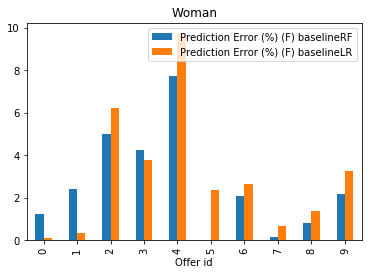

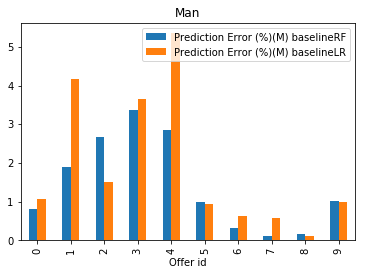

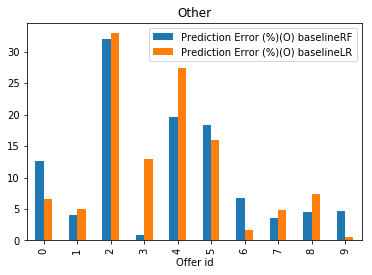

In [143]:
show_error_estimation(df_validation_woman_RF,
                             df_validation_man_RF,
                             df_validation_other_RF,
                             df_validation_woman_LR,
                             df_validation_man_LR,
                             df_validation_other_LR
                             )

,Offer ID,MSE Baseline Random Forest model,MSE Baseline Linear Regression model
0,ae264e3637204a6fb9bb56bc8210ddfd,2542.347088,2543.103081
1,4d5c57ea9a6940dd891ad53e9dbe8da0,2725.950874,2726.501556
2,3f207df678b143eea3cee63160fa8bed,1310.377845,1310.524392
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,1846.782563,1846.664114
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1483.131500,1483.754568
5,2298d6c36e964ae4a3e7e9706d1fb8c2,2371.061505,2371.181122
6,fafdcd668e3743c1bb461111dcafc2a4,4097.390244,4097.136622
7,5a8bc65990b245e5a138643cd4eb9837,1329.982462,1330.244070
8,f19421c1d4aa40978ebb69ca19b0e20d,2715.750693,2714.871226
9,2906b810c7d4411798c6938adc9daaa5,1721.837925,1722.010994


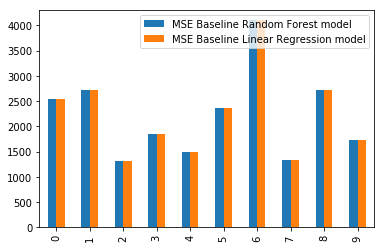

In [144]:
# Show the performance of the baseline models
df_model_baseline_compare = pd.DataFrame(data = {'Offer ID': portfolio_clean.index,
                             'MSE Baseline Random Forest model':all_mse_baseline,
                             'MSE Baseline Linear Regression model':all_mse_baseline_lr})

df_model_baseline_compare.plot.bar()
df_model_baseline_compare

**Conclusion:** The basisline model can guarantee an average error of about 4%, a mean square error (MSE) of 2831.3 euros, and an average R2 score of about -153. These three values will work as basiline to compare to a more complex linear model that will be explained in the next section.

## 3.2. Model based on the client profile

To enhance the model prediction, the full client profile will be used. It will be used six features to train a linear model, notably:

- Client age
- Client income
- Number of days a user is a client member
- Client gender (F, M and O)

In [145]:
all_mse_client_profile = train_RandomForestModel(6,"client_profile", k_fold=5)

--------------------------------------------------------------------- 
Offer: ae264e3637204a6fb9bb56bc8210ddfd
Pickle file: pickle_client_profile_model_revenue_ae264e3637204a6fb9bb56bc8210ddfd.pkl
MSE:  [2977.7058819089307, 1542.6884911025895, 2565.8061522397511, 3664.8598820258098, 3228.0109590726988]
Average mse (net revenue): 2795.81427327
Best param: {'bootstrap': True, 'min_samples_split': 2, 'n_estimators': 30}
--------------------------------------------------------------------- 
Offer: 4d5c57ea9a6940dd891ad53e9dbe8da0
Pickle file: pickle_client_profile_model_revenue_4d5c57ea9a6940dd891ad53e9dbe8da0.pkl
MSE:  [1843.7666439866694, 3339.1165479430892, 3010.9112381631994, 2257.2904101303443, 4436.1735640786383]
Average mse (net revenue): 2977.45168086
Best param: {'bootstrap': True, 'min_samples_split': 4, 'n_estimators': 30}
--------------------------------------------------------------------- 
Offer: 3f207df678b143eea3cee63160fa8bed
Pickle file: pickle_client_profile_model_revenu

In [148]:
all_mse_client_profile_lr = train_LinearRegressionModel(6,"client_profile_lr",k_fold = 5)

--------------------------------------------------------------------- 
Offer: ae264e3637204a6fb9bb56bc8210ddfd
Pickle file: pickle_client_profile_lr_model_revenue_ae264e3637204a6fb9bb56bc8210ddfd.pkl
MSE:  [2639.0343152863807, 1296.4904568588724, 2123.3158554202505, 3595.9455208621825, 2898.4160914015715]
Average mse (net revenue): 2510.64044797
--------------------------------------------------------------------- 
Offer: 4d5c57ea9a6940dd891ad53e9dbe8da0
Pickle file: pickle_client_profile_lr_model_revenue_4d5c57ea9a6940dd891ad53e9dbe8da0.pkl
MSE:  [1523.1007669759915, 3161.3183324843635, 2542.9681454411107, 1894.6840199829289, 4105.2191960735954]
Average mse (net revenue): 2645.45809219
--------------------------------------------------------------------- 
Offer: 3f207df678b143eea3cee63160fa8bed
Pickle file: pickle_client_profile_lr_model_revenue_3f207df678b143eea3cee63160fa8bed.pkl
MSE:  [1238.8006717040284, 869.6797021976322, 683.0868297579359, 1413.0382910737346, 2219.8862838643408]

,Offer ID,MSE Random Forest,MES Linear Regression
0,ae264e3637204a6fb9bb56bc8210ddfd,2795.814273,2510.640448
1,4d5c57ea9a6940dd891ad53e9dbe8da0,2977.451681,2645.458092
2,3f207df678b143eea3cee63160fa8bed,1555.374678,1284.898356
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,2002.447871,1808.706149
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1674.538018,1457.742907
5,2298d6c36e964ae4a3e7e9706d1fb8c2,2432.255490,2258.719883
6,fafdcd668e3743c1bb461111dcafc2a4,4259.443061,3917.608835
7,5a8bc65990b245e5a138643cd4eb9837,1501.532756,1310.511015
8,f19421c1d4aa40978ebb69ca19b0e20d,2894.386638,2641.939962
9,2906b810c7d4411798c6938adc9daaa5,1913.431264,1676.022226


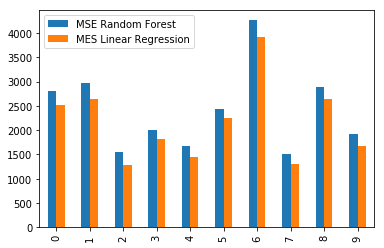

In [149]:
# Show the performance of the client profile model
df_model_client_profile_compare = pd.DataFrame(data = {'Offer ID': portfolio_clean.index,
                     'MSE Random Forest':all_mse_client_profile,
                    'MES Linear Regression': all_mse_client_profile_lr})

df_model_client_profile_compare.plot.bar()
df_model_client_profile_compare


In [ ]:
# Average performance of the model based on the whole client profile
print('AVERAGE PERFORMANCE OF THE MODEL BASED ON THE WHOLE CLIENT PROFILE')
print('Average mse (%):',np.mean(all_mse_client_profile))
#print('Average R2 score (%):',np.mean(all_r2_score_client_profile))
print('MSE difference with the baseline model:', 100*(np.mean(all_mse_client_profile - np.mean(all_mse_baseline)))/np.mean(all_mse_baseline))
#print('R2 score difference with the baseline model:', 100*(np.mean(all_r2_score_client_profile - np.mean(all_r2_score_baseline)))/np.mean(all_r2_score_baseline))



**Conclusion**: The average mse when employing the linear regression with the whole client profile is about 3.6% lower than the basisline model. Despite low, the model using the whole client profile can lead to a better estimation of the offer net revenue.

## 3.3. Model using the whole client profile and the offer channel

Besides the client profile, this third model considers the offer channel (i.e. email, sms, mobile, social, web).

In [150]:
all_mse_client_channel = train_RandomForestModel(10,"client_channel", k_fold=5)

--------------------------------------------------------------------- 
Offer: ae264e3637204a6fb9bb56bc8210ddfd
Pickle file: pickle_client_channel_model_revenue_ae264e3637204a6fb9bb56bc8210ddfd.pkl
MSE:  [3057.0473028591327, 1597.9840767311132, 2351.6042916476858, 3707.8468817756593, 3174.6957669185576]
Average mse (net revenue): 2777.83566399
Best param: {'bootstrap': True, 'min_samples_split': 4, 'n_estimators': 30}
--------------------------------------------------------------------- 
Offer: 4d5c57ea9a6940dd891ad53e9dbe8da0
Pickle file: pickle_client_channel_model_revenue_4d5c57ea9a6940dd891ad53e9dbe8da0.pkl
MSE:  [1838.2979422722981, 3362.077155765614, 3051.5251541934231, 2102.7217012926749, 4561.1494276445355]
Average mse (net revenue): 2983.15427623
Best param: {'bootstrap': True, 'min_samples_split': 4, 'n_estimators': 30}
--------------------------------------------------------------------- 
Offer: 3f207df678b143eea3cee63160fa8bed
Pickle file: pickle_client_channel_model_revenue

In [151]:
all_mse_client_channel_lr = train_LinearRegressionModel(10,"client_channel_lr",k_fold = 5)

--------------------------------------------------------------------- 
Offer: ae264e3637204a6fb9bb56bc8210ddfd
Pickle file: pickle_client_channel_lr_model_revenue_ae264e3637204a6fb9bb56bc8210ddfd.pkl
MSE:  [2638.6854407874443, 1296.3249907383602, 2124.7183386499628, 3594.329968643864, 2901.5191408020382]
Average mse (net revenue): 2511.11557592
--------------------------------------------------------------------- 
Offer: 4d5c57ea9a6940dd891ad53e9dbe8da0
Pickle file: pickle_client_channel_lr_model_revenue_4d5c57ea9a6940dd891ad53e9dbe8da0.pkl
MSE:  [1522.0590644232134, 3164.5287784306288, 2540.2472956785437, 1888.0955215477998, 4105.2298762630462]
Average mse (net revenue): 2644.03210727
--------------------------------------------------------------------- 
Offer: 3f207df678b143eea3cee63160fa8bed
Pickle file: pickle_client_channel_lr_model_revenue_3f207df678b143eea3cee63160fa8bed.pkl
MSE:  [1239.4329134684979, 869.85786934121631, 683.03151037760927, 1412.7586635729899, 2221.0473099079641

In [152]:
# Average performance of the model based on the whole client profile and the offer channel
print('AVERAGE PERFORMANCE OF THE MODEL BASED ON THE WHOLE CLIENT PROFILE AND OFFER CHANNEL')
print('Average mse (%):',np.mean(all_mse_client_channel))
print('MSE difference with the baseline model:', 100*(np.mean(all_mse_client_channel - np.mean(all_mse_baseline)))/np.mean(all_mse_baseline))



AVERAGE PERFORMANCE OF THE MODEL BASED ON THE WHOLE CLIENT PROFILE AND OFFER CHANNEL
Average mse (%): 2400.39789897
MSE difference with the baseline model: 8.39647238792


,Offer ID,MSE Random Forest,MSE Linear Regression
0,ae264e3637204a6fb9bb56bc8210ddfd,2777.835664,2511.115576
1,4d5c57ea9a6940dd891ad53e9dbe8da0,2983.154276,2644.032107
2,3f207df678b143eea3cee63160fa8bed,1470.813198,1285.225653
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,1967.945266,1808.082923
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1734.665232,1459.428561
5,2298d6c36e964ae4a3e7e9706d1fb8c2,2433.496071,2259.717017
6,fafdcd668e3743c1bb461111dcafc2a4,4282.718595,3917.328041
7,5a8bc65990b245e5a138643cd4eb9837,1506.355265,1310.798456
8,f19421c1d4aa40978ebb69ca19b0e20d,2918.485411,2641.667578
9,2906b810c7d4411798c6938adc9daaa5,1928.510013,1675.768120


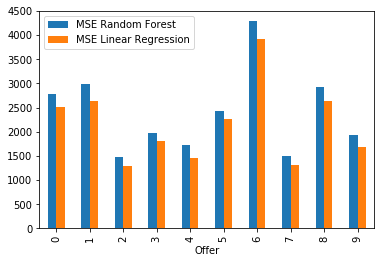

In [156]:
# Show the performance of the model based on the whole client profile and the offer channel
df_model_client_channel_compare = pd.DataFrame(data = {'Offer ID': portfolio_clean.index,
                     'MSE Random Forest':all_mse_client_channel,
                     'MSE Linear Regression':all_mse_client_channel_lr})


df_model_client_channel_compare.plot.bar()
plt.xlabel('Offer')
df_model_client_channel_compare

## 3.4  Comparison between the three linear models

In order to decide which linear model to use, the MSE of each of the three models will be compared. 

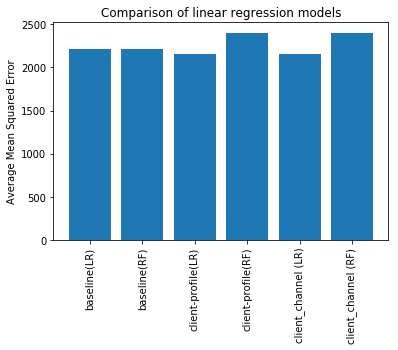

In [158]:

y = [np.mean(all_mse_client_channel),
     np.mean(all_mse_baseline),
     np.mean(all_mse_client_profile),
     np.mean(all_mse_client_channel_lr),
     np.mean(all_mse_baseline_lr),
     np.mean(all_mse_client_profile_lr)]
x = ['client_channel (RF)',
     'baseline(RF)',
     'client-profile(RF)',
     'client_channel (LR)',
     'baseline(LR)',
     'client-profile(LR)',]

plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Average Mean Squared Error')
plt.title('Comparison of linear regression models')
plt.show()


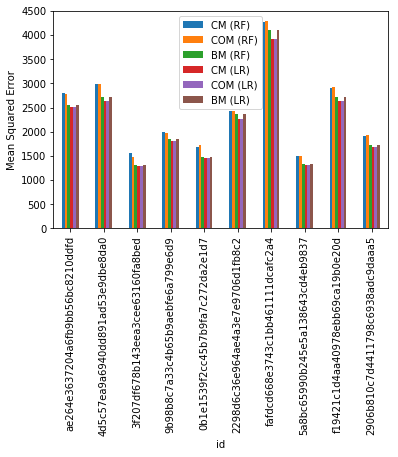

In [159]:
df_mse_comparison  = pd.DataFrame(data = { 'CM (RF)': all_mse_client_profile,
                                           'COM (RF)': all_mse_client_channel,
                                           'BM (RF)':all_mse_baseline,
                                           'CM (LR)': all_mse_client_profile_lr,
                                           'COM (LR)': all_mse_client_channel_lr,
                                           'BM (LR)':all_mse_baseline_lr})
df_mse_comparison.index = portfolio['id']

df_mse_comparison.plot.bar()
plt.ylabel('Mean Squared Error')
plt.show()

**Conclusion:** The client-profile (section 3.2) and client-channel models (section 3.3) resulted in the mean square error very similar. Therefore, this indicates that the offer channel does not influence the net revenue estimation. To simplify the linear regression model, it is better to use the client-profile model to build a recommendation engine.


# 4. The recommendation engines

## 4.1. Based on the linear regression model

In [326]:
def recommendation_engine_linear_regression(client_id, show_results = True, n_top = 3):
    '''
        INPUT: 
            client_id: ID number identifying a client
            show_results: boolean variable indicating whether the results are going to be printed or not
            n_top: integer variable indicaing the number of offers to be recommended to the client
        OUTPUT:
            best_offer_id: (list) The best 'n_top' offers to send to the client
            df_recommendation_lr: dataframe containing the ranked offers to send to the client
    '''
    all_net_revenue_pred = []
    
    # Get the client's profile
    client_profile = profile_clean.iloc[:,-6:]
    client_profile = client_profile[profile_clean.index == client_id].values
    for offer_id in portfolio['id']:

            # Load the linear regression trained model
            pkl_filename = "pickle_client_profile_lr_model_revenue_" + offer_id + ".pkl"
            with open(pkl_filename, 'rb') as file:
                model = pickle.load(file)
            
            # Calculate the expected net revenue
            net_revenue_pred = model.predict(np.array(client_profile).reshape(1,-1))[0]

            all_net_revenue_pred.append(net_revenue_pred)

    # Store the results in a dataframe
    df_recommendation_lr = pd.DataFrame({'offer_id': portfolio['id'],
                                    'net_revenue': all_net_revenue_pred})
    # Get the offer_id with the maximum net revenue as the best offer
    best_offer_id = df_recommendation_lr.sort_values(by=['net_revenue'],ascending=False)['offer_id'].values[:min(len(df_recommendation_lr),n_top)]

    
    if show_results:
        print('For client ', client_id, ', the best offer is ', best_offer_id)

    return df_recommendation_lr,best_offer_id

# Test of the recommendation engine using linear regression
client_id = profile_clean.index[400]
df_recommendation_lr,best_offer_id = recommendation_engine_linear_regression(client_id)

For client  b3e4bca407e849568ceec8454336bc24 , the best offer is  ['fafdcd668e3743c1bb461111dcafc2a4' '2298d6c36e964ae4a3e7e9706d1fb8c2'
 'ae264e3637204a6fb9bb56bc8210ddfd']


In [327]:
# Show the ranked offers to send to the user based on the expected net revenue
df_recommendation_lr

,offer_id,net_revenue
0,ae264e3637204a6fb9bb56bc8210ddfd,25.562500
1,4d5c57ea9a6940dd891ad53e9dbe8da0,19.000000
2,3f207df678b143eea3cee63160fa8bed,10.414062
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,13.941895
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,7.289062
5,2298d6c36e964ae4a3e7e9706d1fb8c2,26.765625
6,fafdcd668e3743c1bb461111dcafc2a4,28.835938
7,5a8bc65990b245e5a138643cd4eb9837,19.000000
8,f19421c1d4aa40978ebb69ca19b0e20d,22.195312
9,2906b810c7d4411798c6938adc9daaa5,15.812500


# 5 . Running the recommendation engine

For each client in the **profile_clean** dataset, the recommendation engine using linear regression will be determine the best offer for each client profile based on the expected net revenue. 

In [328]:
# Create list for the top 3 offers to send to a client
all_choices_1 = []
all_choices_2 = []
all_choices_3 = []
count = 0
for client_id in profile_clean.index:
    count += 1
    if count % 100 ==0:
        print(count, '/', len(profile_clean.index))

    _,best_offer_id = recommendation_engine_linear_regression(client_id, show_results=False)

    # Append the offers recommendations in the lists
    all_choices_1.append(best_offer_id[0])
    all_choices_2.append(best_offer_id[1])
    all_choices_3.append(best_offer_id[2])




100 / 14825
200 / 14825
300 / 14825
400 / 14825
500 / 14825
600 / 14825
700 / 14825
800 / 14825
900 / 14825
1000 / 14825
1100 / 14825
1200 / 14825
1300 / 14825
1400 / 14825
1500 / 14825
1600 / 14825
1700 / 14825
1800 / 14825
1900 / 14825
2000 / 14825
2100 / 14825
2200 / 14825
2300 / 14825
2400 / 14825
2500 / 14825
2600 / 14825
2700 / 14825
2800 / 14825
2900 / 14825
3000 / 14825
3100 / 14825
3200 / 14825
3300 / 14825
3400 / 14825
3500 / 14825
3600 / 14825
3700 / 14825
3800 / 14825
3900 / 14825
4000 / 14825
4100 / 14825
4200 / 14825
4300 / 14825
4400 / 14825
4500 / 14825
4600 / 14825
4700 / 14825
4800 / 14825
4900 / 14825
5000 / 14825
5100 / 14825
5200 / 14825
5300 / 14825
5400 / 14825
5500 / 14825
5600 / 14825
5700 / 14825
5800 / 14825
5900 / 14825
6000 / 14825
6100 / 14825
6200 / 14825
6300 / 14825
6400 / 14825
6500 / 14825
6600 / 14825
6700 / 14825
6800 / 14825
6900 / 14825
7000 / 14825
7100 / 14825
7200 / 14825
7300 / 14825
7400 / 14825
7500 / 14825
7600 / 14825
7700 / 14825
7800 / 1

In [329]:
# Structure the best offers in a Dataframe
best_offer_per_client = pd.DataFrame(data = {'user_id': profile_clean.index,
                                        'all_choices_1':all_choices_1,
                                        'all_choices_2':all_choices_2,
                                        'all_choices_3': all_choices_3})

# Join the best offer results to the client profile
df_best_offer_per_client = best_offer_per_client.set_index('user_id').join(profile_clean)

# Show the head of the result
df_best_offer_per_client.head()

,all_choices_1,all_choices_2,all_choices_3,age,income,client_duration_days,F,M,O
user_id,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,fafdcd668e3743c1bb461111dcafc2a4,2298d6c36e964ae4a3e7e9706d1fb8c2,f19421c1d4aa40978ebb69ca19b0e20d,55,112000.0,1389,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,fafdcd668e3743c1bb461111dcafc2a4,2298d6c36e964ae4a3e7e9706d1fb8c2,f19421c1d4aa40978ebb69ca19b0e20d,75,100000.0,1456,1,0,0
e2127556f4f64592b11af22de27a7932,fafdcd668e3743c1bb461111dcafc2a4,2298d6c36e964ae4a3e7e9706d1fb8c2,f19421c1d4aa40978ebb69ca19b0e20d,68,70000.0,1104,0,1,0
389bc3fa690240e798340f5a15918d5c,fafdcd668e3743c1bb461111dcafc2a4,2298d6c36e964ae4a3e7e9706d1fb8c2,f19421c1d4aa40978ebb69ca19b0e20d,65,53000.0,1180,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,fafdcd668e3743c1bb461111dcafc2a4,2298d6c36e964ae4a3e7e9706d1fb8c2,ae264e3637204a6fb9bb56bc8210ddfd,58,51000.0,1270,0,1,0


### The offer ranked in #1:

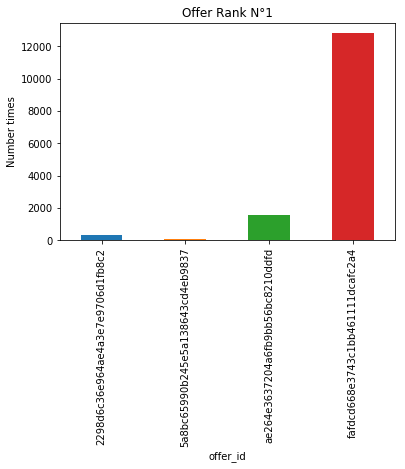

In [330]:
# Count the number of times a offer was ranked as the best one
df_best_offer_per_client.groupby('all_choices_1').count().iloc[:,1].plot.bar()
plt.xlabel('offer_id')
plt.ylabel('Number times')
plt.title('Offer Rank N°1')
plt.show()

In [331]:
# Statistics for the offer in rank 1
best_offer_rank1 = df_best_offer_per_client['all_choices_1'].unique()
df_stats_offer_rank1 = df_best_offer_per_client.groupby('all_choices_1').mean()

df_stats_offer_rank1 = df_stats_offer_rank1.join(portfolio_clean)
df_stats_offer_rank1.drop(columns = ['id'])

,age,income,client_duration_days,F,M,O,difficulty,duration,offer_type,reward,email,mobile,social,web
all_choices_1,,,,,,,,,,,,,,
2298d6c36e964ae4a3e7e9706d1fb8c2,45.169643,60214.285714,1381.863095,0.416667,0.000000,0.583333,7,7,discount,3,1,1,1,1
5a8bc65990b245e5a138643cd4eb9837,57.771429,35257.142857,1062.209524,0.085714,0.914286,0.000000,0,3,informational,0,1,1,1,0
ae264e3637204a6fb9bb56bc8210ddfd,32.607731,38190.747782,1328.019645,0.248416,0.742079,0.009506,10,7,bogo,10,1,1,1,0
fafdcd668e3743c1bb461111dcafc2a4,57.292363,69141.808527,1568.953850,0.436358,0.563564,0.000078,10,10,discount,2,1,1,1,1


### The offer ranked in #2:

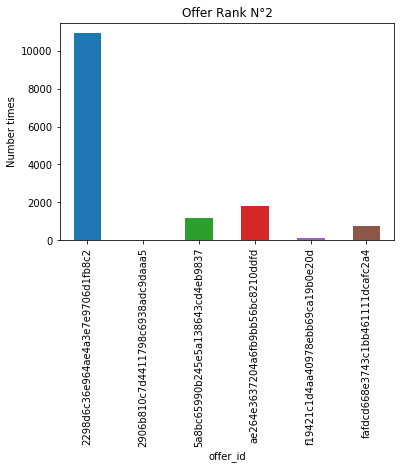

In [332]:
# Count the number of times a offer was ranked in the second place
df_best_offer_per_client.groupby('all_choices_2').count().iloc[:,1].plot.bar()
plt.xlabel('offer_id')
plt.ylabel('Number times')
plt.title('Offer Rank N°2')
plt.show()

In [333]:
# Statistics for the offer in rank 2

best_offer_rank1 = df_best_offer_per_client['all_choices_2'].unique()
df_stats_offer_rank2 = df_best_offer_per_client.groupby('all_choices_2').mean()

df_stats_offer_rank2 = df_stats_offer_rank2.join(portfolio_clean)
df_stats_offer_rank2 = df_stats_offer_rank2.drop(columns = ['id'])
df_stats_offer_rank2

,age,income,client_duration_days,F,M,O,difficulty,duration,offer_type,reward,email,mobile,social,web
all_choices_2,,,,,,,,,,,,,,
2298d6c36e964ae4a3e7e9706d1fb8c2,58.259747,72991.213619,1573.424767,0.527824,0.470712,0.001464,7,7,discount,3,1,1,1,1
2906b810c7d4411798c6938adc9daaa5,94.500000,30500.000000,1471.000000,0.000000,1.000000,0.000000,10,7,discount,2,1,1,0,1
5a8bc65990b245e5a138643cd4eb9837,42.137272,38305.821025,1175.931364,0.104257,0.895743,0.000000,0,3,informational,0,1,1,1,0
ae264e3637204a6fb9bb56bc8210ddfd,44.616393,45645.901639,1597.813661,0.038251,0.922404,0.039344,10,7,bogo,10,1,1,1,0
f19421c1d4aa40978ebb69ca19b0e20d,69.676056,53154.929577,1103.964789,0.000000,1.000000,0.000000,5,5,bogo,5,1,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,38.251938,47669.250646,1466.454780,0.222222,0.617571,0.160207,10,10,discount,2,1,1,1,1


### The offer ranked in #3:

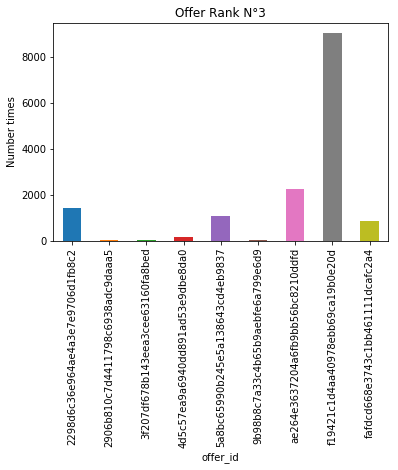

In [334]:
# Count the number of times a offer was ranked in the third place
df_best_offer_per_client.groupby('all_choices_3').count().iloc[:,1].plot.bar()
plt.xlabel('offer_id')
plt.ylabel('Number times')
plt.title('Offer Rank N°3')
plt.show()


In [335]:
# Statistics for the offer in rank 3

best_offer_rank1 = df_best_offer_per_client['all_choices_2'].unique()
df_stats_offer_rank3 = df_best_offer_per_client.groupby('all_choices_2').mean()

df_stats_offer_rank3 = df_stats_offer_rank3.join(portfolio_clean)
df_stats_offer_rank3 = df_stats_offer_rank3.drop(columns = ['id'])
df_stats_offer_rank3

,age,income,client_duration_days,F,M,O,difficulty,duration,offer_type,reward,email,mobile,social,web
all_choices_2,,,,,,,,,,,,,,
2298d6c36e964ae4a3e7e9706d1fb8c2,58.259747,72991.213619,1573.424767,0.527824,0.470712,0.001464,7,7,discount,3,1,1,1,1
2906b810c7d4411798c6938adc9daaa5,94.500000,30500.000000,1471.000000,0.000000,1.000000,0.000000,10,7,discount,2,1,1,0,1
5a8bc65990b245e5a138643cd4eb9837,42.137272,38305.821025,1175.931364,0.104257,0.895743,0.000000,0,3,informational,0,1,1,1,0
ae264e3637204a6fb9bb56bc8210ddfd,44.616393,45645.901639,1597.813661,0.038251,0.922404,0.039344,10,7,bogo,10,1,1,1,0
f19421c1d4aa40978ebb69ca19b0e20d,69.676056,53154.929577,1103.964789,0.000000,1.000000,0.000000,5,5,bogo,5,1,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,38.251938,47669.250646,1466.454780,0.222222,0.617571,0.160207,10,10,discount,2,1,1,1,1
